# Adaptive ESN dim

In [ ]:
## This code explores the dynamical change of feature matrix --> ESN when NaN values are removed

## Config

In [1]:
path = '../../training_1/'

from os import listdir
print(len(listdir(path))-int('README.md' in (listdir(path))), 'files')
n = len(listdir(path))-int('README.md' in (listdir(path)))


def print_config(path):
    print("Path: ", path)
    return

script_name = "ESN_custom_norm_featvec"
dl_ = '_'
name_struct_meta = "_N_scale_mem"
print_config(path)

5000 files
Path:  ../training_1/


## Function to get sepsis patients

In [2]:
## Get sepsis patients MODIFIED
def get_sepsis_patients(sepsis_label, patient):
    patient_sep = np.zeros(len(sepsis_label),dtype=np.int)
    for i in range(len(np.unique(patient))):
        i_pat = np.where(patient==i)[0]
        patient_sep[i_pat] = int(np.sum(sepsis_label[i_pat])>0)*np.ones(len(i_pat), dtype=np.int)
        
    patient_sep_idx = np.where(patient_sep!=0)[0]
    patient_healthy_idx = np.where(patient_sep==0)[0]
    return patient_sep, patient_sep_idx, patient_healthy_idx

## Load ICU sepsis data log

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import math as m
from os import listdir
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold

In [4]:
fnames = listdir(path)  
fnames.sort()
if 'README.md' in fnames:
    fnames.remove('README.md')
fnames[-1]

'p05000.psv'

In [5]:
# Count sample patients
sample_num = len(fnames)
sample_num

5000

In [6]:
# Import and print dataframe layout
def loadICUdata(fname, printdf = False):
    df = pd.read_csv(fname, sep = '|')
    #print(fname, ' file:')
    if printdf:
        print(df)
    return df

print(fnames[0])
# Example with first patient 
df = loadICUdata(path + fnames[0], False)
# df

p00001.psv


## Sepsis keys for the ESN

In [7]:
# We use features defined by the user
s_keys = []
with open(path + fnames[0], 'r') as f:
    header = f.readline().strip()
    s_keys = header.split('|')
    
# s_keys = ['HR', 'O2Sat', 'SBP', 'MAP', 'DBP', 'Age', 'Gender', 'HospAdmTime', 'ICULOS'] #, 'SepsisLabel']
type(s_keys)
len(s_keys)

41

In [8]:
feature_matrix = np.load('../../npy/training_1.npy')
sepsis_label = np.load('../npy/../training_1_Y.npy')
patient = np.load('../npy/../training_1_patient.npy')
dataloaded = True

In [9]:
print(feature_matrix.shape)
print(sepsis_label.shape)
print(patient.shape)

(188453, 40)
(188453,)
(188453,)


In [10]:
feature_matrix
np.shape(feature_matrix)

(188453, 40)

In [11]:
## Separate pointers
feature_phys = feature_matrix[:,:-6]    ## Physiology
feature_demog = feature_matrix[:,-6:]   ## Demographics

In [12]:
# Keep a raw copy
raw_feature_matrix = np.copy(feature_matrix)

In [13]:
patient
np.shape(patient)

(188453,)

In [14]:
sepsis_label
np.shape(sepsis_label)

(188453,)

In [15]:
# Single entry example
# i_e = 90000
# print(patient[i_e])
# print(feature_matrix[i_e,:])
# print(sepsis_label[i_e])


In [16]:
if 'HR' in s_keys:
    print(feature_matrix[:,s_keys.index('HR')]) 
    print(len(feature_matrix[:,s_keys.index('HR')]))

[nan 93. 91. ... 94. 90. 81.]
188453


24 entries x 40


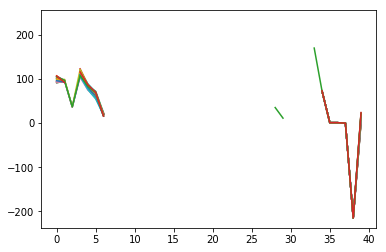

In [17]:
i_pat = 0

def plot_patient_features(n_pat, features, patient_array):
    plot_j = np.where(patient == n_pat)[0]
    for j in range (len(plot_j)):
        plt.plot(features[plot_j[j],:])    
    print(len(plot_j), "entries x", np.shape(features)[1])
    return

def print_patient_features(n_pat, features, patient_array):
    print("Patient", n_pat)
    print_j = np.where(patient == n_pat)[0]
    for j in range (len(print_j)):
        print(features[print_j[j],:])    
    return

plot_patient_features(i_pat, feature_matrix, patient)

In [18]:
# RESET
feature_matrix= np.copy(raw_feature_matrix)

In [19]:
# STATS
# np.nanmean(feature_phys, axis=0)

## Normalise

In [20]:
## (Get sepsis patients)
patient_sep, patient_sep_idx, patient_healthy_idx = get_sepsis_patients(sepsis_label, patient)

In [21]:
len(patient_sep_idx)
len(patient_healthy_idx)

172929

In [22]:
len(patient_sep)

188453

In [23]:
print(patient_healthy_idx)

[     0      1      2 ... 188450 188451 188452]


In [24]:
## Separate pointers
feature_phys = feature_matrix[:,:-6]    ## Physiology
feature_demog = feature_matrix[:,-6:]   ## Demographics

In [25]:
## Normalize mm(all) or std (sepsis, phys) vals, feature-based
scaler = MinMaxScaler()
for i in range(len(np.unique(patient))):
    i_pat = np.where(patient==i)[0]
    scaler.fit(feature_matrix[i_pat,:])
    feature_matrix[i_pat,:] = scaler.transform(feature_matrix[i_pat,:])

/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anacon

/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anacon

/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anacon

/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anacon

/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anacon

/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anacon

/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anacon

/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anacon

/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anacon

/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:364: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/mnt/sda1/anaconda3_mint/lib/python3.7/site-packages/sklearn/preprocessing/data.py:365: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/mnt/sda1/anacon

24 entries x 34


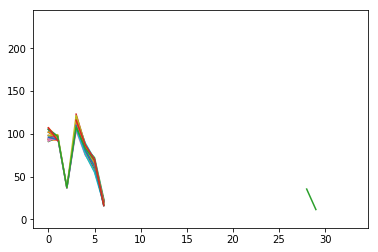

In [26]:
plot_patient_features(0, raw_feature_matrix[:,:-6], patient)

24 entries x 34


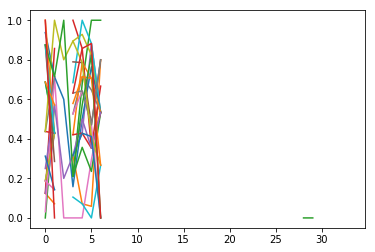

In [27]:
plot_patient_features(0, feature_phys, patient)

In [28]:
np.max(raw_feature_matrix[:,38])

0.0

## ESN

In [29]:
import ESNtools

In [30]:
np.random.seed(seed=0)

In [31]:
## ESN Generation parameters
N = 200
mem = 0.5
scale = 1
sigmoid_exponent = 0.1
func = ESNtools.sigmoid         # sigmoid

name_struct = [dl_, N, dl_, scale, dl_, mem]
name_struct = ''.join(str(e) for e in name_struct)

In [32]:
# ESN = np.hstack((np.matmul(features, mask), np.ones((np.shape(features)[0],1), dtype=np.double)))
# print(np.shape(ESN))
# print(np.min(ESN), np.max(ESN))
# p = np.zeros((1,neurons),dtype=np.double)

# for i in range(np.shape(features)[0]):
#     in_val = scale * (ESN[i,:-1] + mask_bias) + p * mem
    
#     ## Apply transform
#     ESN[i,:-1] = func(in_val, f_arg)
    
#     ## Connect preceding neighbour 
#     p = np.copy(np.roll(ESN[i,:-1],1))

In [33]:
## Mask parameters
M = 2*np.random.rand(np.shape(feature_matrix)[1],N)-1
Mb = 2*np.random.rand(1,N)-1

In [34]:
ESN = (np.ones((np.shape(feature_matrix)[0],N+1), dtype=np.double))
ESN.shape

(188453, 201)

In [35]:
# Dynamical (dim) ESN feed
for i in range(len(feature_matrix)):
    feat_i = feature_matrix[i,:]
    idx = np.where(np.isfinite(feat_i)==True)[0]
    row = feat_i[idx].reshape(-1,len(idx))
    
    m = M[:len(idx),:]
    ESN[i,:-1] = np.matmul(row,m)

In [36]:
# Compute nonlinear mapping function
p = np.zeros((1,N),dtype=np.double)
for i in range(np.shape(feature_matrix)[0]):
    in_val = scale * (ESN[i,:-1] + Mb) + p * mem

    ## Apply transform
    ESN[i,:-1] = func(in_val, sigmoid_exponent)

    ## Connect preceding neighbour 
    p = np.copy(np.roll(ESN[i,:-1],1))


## CV Loop

In [37]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
dataset = "training_1"
path = "../" + dataset +"/"
kfold_split = 10

In [38]:
## Divide in sets
X = ESN
Y = sepsis_label
groups = patient

skf = StratifiedKFold(n_splits=kfold_split)
skf.get_n_splits(X)




## KFold
results = []
target = []
kk = 0
for train_index, test_index in skf.split(X,Y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    ## Obtain weights
    w = ESNtools.get_weights_lu_biasedNE(ESN, Y)       
    Y_pred = (np.matmul(X_test,w))
    print(kk, ' realisation ')
    print("auc: ", roc_auc_score(y_test, Y_pred))
    kk +=1
    target.append(y_test)
    results.append(Y_pred)

## Evaluate results
results = np.concatenate(results)
target = np.concatenate(target)
auc = roc_auc_score(target,results)
print('auc: ', auc)

## Threshold study
th_i = np.min(results)
th_f = np.max(results)
th_steps = 1000
th_step = (th_f-th_i)/th_steps
thsum = 0
th = np.zeros((1000, 1), dtype = np.double)
f1 =np.zeros((1000, 1), dtype = np.double)

print("Threshold: Loop between ",  th_i, th_i+th_step*th_steps)
for i, j in enumerate(np.arange(th_i, th_f, th_step)):
    th[i] = j
    f1[i] = f1_score(target, results > th[i])
    thsum = thsum + th[i]
    if i%100 == 0:
        print(i, th[i], f1[i])

    if f1[i] < 0.001 and np.abs(thsum) > 0:
        th = th[:i]
        f1 = f1[:i]
        break

## Max Threshold
th_max = th[np.argmax(f1)]

## Metrics
Pr = precision_score(target, results > th_max)
Re = recall_score(target, results > th_max)
ACC = accuracy_score(target, results > th_max)
auc = roc_auc_score(target, results)
f1 = f1_score(target, results > th_max)

patient_sep = np.zeros(len(sepsis_label),dtype=np.int)
for i in range(n):
    i_pat = np.where(patient==i)[0]
    patient_sep[i_pat] = int(np.sum(sepsis_label[i_pat])>0)*np.ones(len(i_pat), dtype=np.int)
    
np.sum(patient_sep)

np.sum(sepsis_label)

import platform
import time

user = platform.uname()[1] + '@' + platform.platform() 
# dir_path = os.path.dirname(os.path.realpath(__file__))
dir_path = "IPython"

# write to report file
output_file = 'report_' + script_name + name_struct + '.txt'
with open(output_file, 'w') as f:
    f.write(user + '\n')
    f.write(dir_path + '\n')
    f.write(time.strftime("%Y-%m-%d %H:%M") + '\n')
    f.write('Dataset: ' + path + '\n')
    f.write('%d \t N\n' % N)
    f.write('%2.4f \t exp\n' % sigmoid_exponent)
    f.write('%2.4f \t mem\n' % mem)
    f.write('%2.4f \t scale\n' % scale)
    f.write('(%2.4f, %2.4f, %2.4f) \t th_i, th_f, *th_sc\n' % (th_i, th_f, th_f-th_i))
    f.write('%2.4f \t th\n' % th_max)
    f.write('%2.4f \t Pr\n' % Pr)
    f.write('%2.4f \t Re\n' % Re)
    f.write('%2.4f \t F1\n' % f1)
    f.write('%2.4f \t ACC\n' % ACC)
    f.write('%2.4f \t AUC\n' % auc)
    
print(user)
print(dir_path)
print(time.strftime("%Y-%m-%d %H:%M"))
print('Dataset: ' + path)
print('N: %d' % N)
print('exp: %2.4f' % sigmoid_exponent)
print('mem: %2.4f' % mem)
print('scale: %2.4f' % scale)
print('th_i, th_f, *th_sc: (%2.4f, %2.4f, %2.4f)' % (th_i, th_f, th_f-th_i))
print('th: %2.4f' % th_max)
print('Pr: %2.4f' % Pr)
print('Re: %2.4f' % Re)
print('F1: %2.4f' % f1)
print('ACC: %2.4f' % ACC)
print('AUC: %2.4f' % auc)

## Write results
# write to report file
res = 'res_' + script_name + name_struct + '.out'
with open(res, 'w') as f:
    f.write('Target|Predicted|PredictedLabel %g' % th_max)
    if dataloaded:
        for (s, l) in zip(target, results):
            f.write('\n%d|%g|%d' % (s, l, int(l>th_max)))

0  realisation 
auc:  0.8190050229890397
1  realisation 
auc:  0.779358418473567
2  realisation 
auc:  0.8273322708579676
3  realisation 
auc:  0.7928988285689991
4  realisation 
auc:  0.7521162533432634
5  realisation 
auc:  0.7570390815211966
6  realisation 
auc:  0.7806180482612975
7  realisation 
auc:  0.7710324177930007
8  realisation 
auc:  0.8033390938857767
9  realisation 
auc:  0.7613046562708344
auc:  0.784255287746853
Threshold: Loop between  -0.1802400442337273 0.4226366677228306
0 [-0.18024004] [0.02745519]
100 [-0.11995237] [0.02745706]
200 [-0.0596647] [0.02746369]
300 [0.00062297] [0.03181547]
400 [0.06091064] [0.08874743]
500 [0.12119831] [0.02895553]
600 [0.18148598] [0.01928783]
700 [0.24177365] [0.00980392]
800 [0.30206133] [0.00455581]
900 [0.362349] [0.0007622]
omen@Linux-4.8.0-53-generic-x86_64-with-debian-stretch-sid
IPython
2019-07-23 12:19
Dataset: ../training_1/
N: 200
exp: 0.1000
mem: 0.5000
scale: 1.0000
th_i, th_f, *th_sc: (-0.1802, 0.4226, 0.6029)
th: 0.0